# Multiple Regression

This episode is a discussion of multiple regression: the use of observations that are a vector of values to predict a response variable.  For this episode, we consider how features of a home such as the number of bedrooms, number of bathrooms, and square footage can predict the sale price.

Unlike a typical episode of Data Skeptic, these show notes are not just supporting material, but are actually featured in the episode.

The site Redfin gratiously allows users to download a CSV of results they are viewing.  Unfortunately, they limit this extract to 500 listings, but you can still use it to try the same approach on your own using the download link shown in the figure below.

<img src='redfin.png' width=300 />

In [165]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm

## Data loading, cleaning, and munging

In [4]:
file = 'redfin_2016-02-06-20-27-26_results.csv'
df = pd.read_csv(file)

In [34]:
df['IS SHORT SALE'] = df['IS SHORT SALE'].fillna(0).astype(int)
df['LAST SALE DATE'] = pd.to_datetime(df['LAST SALE DATE'])
df['LAST SALE MONTH'] = df['LAST SALE DATE'].apply(lambda x: str(x.year) + '-' + str(x.month).zfill(2))
df['intercept'] = 1

In [6]:
df.columns

Index([u'SALE TYPE', u'HOME TYPE', u'ADDRESS', u'CITY', u'STATE', u'ZIP',
       u'LIST PRICE', u'BEDS', u'BATHS', u'LOCATION', u'SQFT', u'LOT SIZE',
       u'YEAR BUILT', u'PARKING SPOTS', u'PARKING TYPE', u'DAYS ON MARKET',
       u'STATUS', u'NEXT OPEN HOUSE DATE', u'NEXT OPEN HOUSE START TIME',
       u'NEXT OPEN HOUSE END TIME', u'RECENT REDUCTION DATE',
       u'ORIGINAL LIST PRICE', u'LAST SALE DATE', u'LAST SALE PRICE',
       u'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
       u'SOURCE', u'LISTING ID', u'ORIGINAL SOURCE', u'FAVORITE',
       u'INTERESTED', u'LATITUDE', u'LONGITUDE', u'IS SHORT SALE'],
      dtype='object')

In [ ]:
[u'SALE TYPE', u'HOME TYPE', u'ADDRESS', u'CITY', u'STATE', u'ZIP',
       u'LIST PRICE', u'BEDS', u'BATHS', u'LOCATION', u'SQFT', u'LOT SIZE',
       u'YEAR BUILT', u'PARKING SPOTS', u'PARKING TYPE', u'DAYS ON MARKET',
       u'STATUS', u'NEXT OPEN HOUSE DATE', u'NEXT OPEN HOUSE START TIME',
       u'NEXT OPEN HOUSE END TIME', u'RECENT REDUCTION DATE',
       u'ORIGINAL LIST PRICE', u'LAST SALE DATE', u'LAST SALE PRICE',
       u'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
       u'SOURCE', u'LISTING ID', u'ORIGINAL SOURCE', u'FAVORITE',
       u'INTERESTED', u'LATITUDE', u'LONGITUDE', u'IS SHORT SALE'],

## Some miscellaneous data exploration

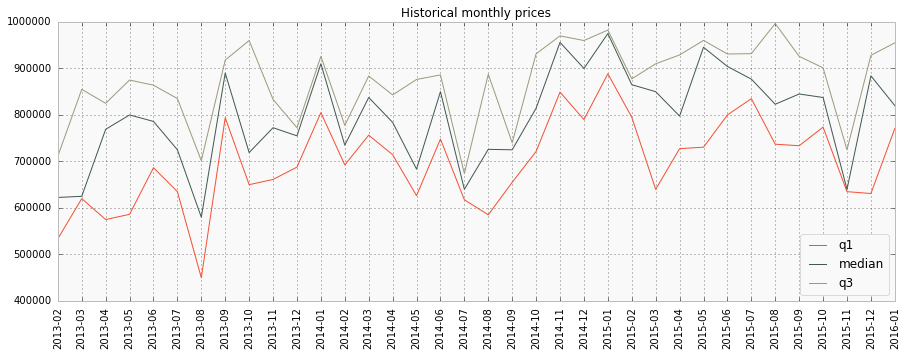

In [77]:
# Overall trend of prices for the input by month
h_mean = df.groupby(['LAST SALE MONTH'])['LAST SALE PRICE'].mean()
h_q1 = df.groupby(['LAST SALE MONTH'])['LAST SALE PRICE'].quantile(.25)
h_q2 = df.groupby(['LAST SALE MONTH'])['LAST SALE PRICE'].quantile(.5)
h_q3 = df.groupby(['LAST SALE MONTH'])['LAST SALE PRICE'].quantile(.75)
historical = pd.concat([h_q1, h_q2, h_q3, h_mean], axis=1)
historical.columns = ['q1', 'median', 'q3', 'mean']
historical = historical.reset_index()
plt.figure(figsize=(15,5))
#plt.plot(historical.index, historical['mean'])
plt.plot(historical.index, historical['q1'])
plt.plot(historical.index, historical['median'])
plt.plot(historical.index, historical['q3'])
plt.xticks(historical.index, historical['LAST SALE MONTH'], rotation=90)
plt.legend(loc=4)
plt.title('Historical monthly prices')
plt.show()

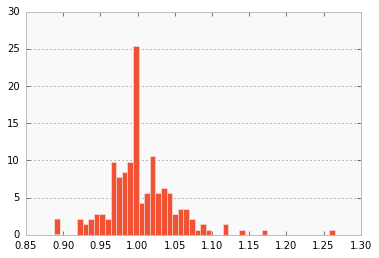

In [83]:
# RATIO OF LAST SALE PRICE TO LISTING PRICE (i.e. margin of negotation)
delta = df['LAST SALE PRICE'] / df['LIST PRICE']
delta.dropna(inplace=True)
n, bins, patches = plt.hist(delta, 50, normed=1)
plt.gca().xaxis.grid(False)

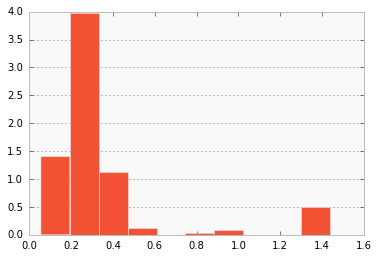

In [92]:
# RATIO OF SQFT TO LOT SIZE (just for fun)
delta = df['SQFT'] / df['LOT SIZE']
delta.dropna(inplace=True)
n, bins, patches = plt.hist(delta, 10, normed=1)
plt.gca().xaxis.grid(False)

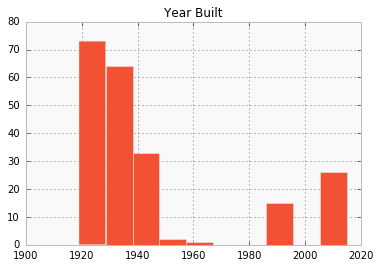

In [87]:
df['YEAR BUILT'].hist()
plt.title('Year Built')
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  from ipykernel import kernelapp as app


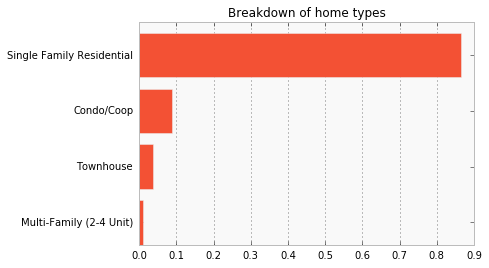

In [116]:
ht = df.groupby(['HOME TYPE'])['HOME TYPE'].count()
ht.sort(inplace=True)
ht = pd.DataFrame(ht)
ht.columns=['count']
ht['count'] = ht['count'] / sum(ht['count'])
ht.reset_index(inplace=True)
plt.barh(ht.index, ht['count'])
plt.yticks(ht.index + 0.4, ht['HOME TYPE'])
plt.gca().yaxis.grid(False)
plt.title('Breakdown of home types')
plt.show()

## Feature Exploration

Let's do some visualizations of our features before we blindly shove them into OLS.

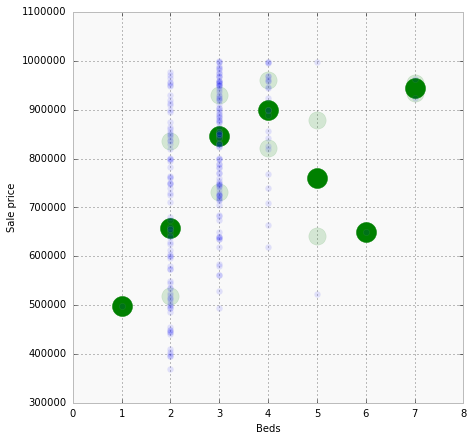

In [150]:
plt.figure(figsize=(7,7))
gb = df.groupby(['BEDS'])['LAST SALE PRICE'].median()
plt.scatter(gb.index, gb, color='green', s=400, alpha=1)
gb = df.groupby(['BEDS'])['LAST SALE PRICE'].quantile(.25)
plt.scatter(gb.index, gb, color='green', s=300, alpha=0.15)
gb = df.groupby(['BEDS'])['LAST SALE PRICE'].quantile(.75)
plt.scatter(gb.index, gb, color='green', s=300, alpha=0.15)
plt.scatter(df['BEDS'], df['LAST SALE PRICE'], alpha=0.1, s=40)
plt.xlabel('Beds')
plt.ylabel('Sale price')
plt.show()

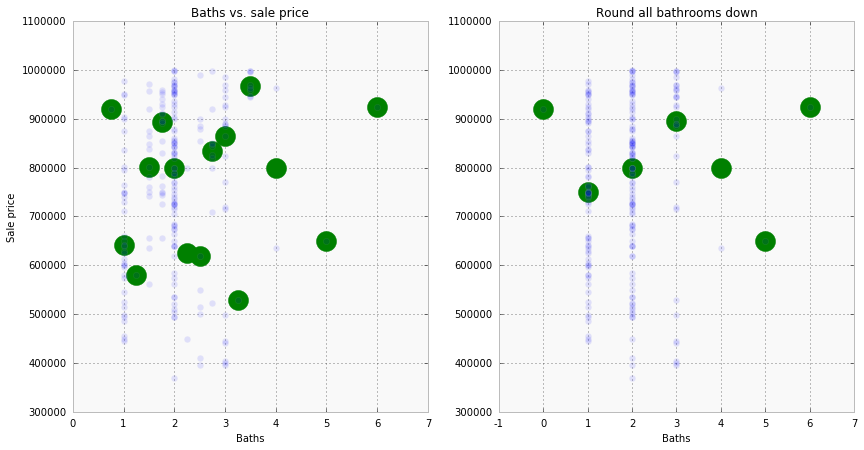

In [173]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121)

df['fBATHS'] = df['BATHS'].apply(math.floor)

gb = df.groupby(['BATHS'])['LAST SALE PRICE'].median()
ax1.scatter(gb.index, gb, color='green', s=400, alpha=1)
ax1.scatter(df['BATHS'], df['LAST SALE PRICE'], alpha=0.1, s=40)
ax1.set_title('Baths vs. sale price')
ax1.set_xlabel('Baths')
ax1.set_ylabel('Sale price')

ax2 = fig.add_subplot(122)

gb = df.groupby(['fBATHS'])['LAST SALE PRICE'].median()
ax2.scatter(gb.index, gb, color='green', s=400, alpha=1)
ax2.scatter(df['fBATHS'], df['LAST SALE PRICE'], alpha=0.1, s=40)
ax2.set_title('Round all bathrooms down')
ax2.set_xlabel('Baths')

plt.show()

In [205]:
f = sm.OLS(df['LAST SALE PRICE'], df[['intercept', 'SQFT']], missing='drop').fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LAST SALE PRICE   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     76.43
Date:                Sun, 07 Feb 2016   Prob (F-statistic):           7.22e-16
Time:                        05:55:56   Log-Likelihood:                -2830.6
No. Observations:                 213   AIC:                             5665.
Df Residuals:                     211   BIC:                             5672.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept   4.696e+05   3.59e+04     13.081      0.000      3.99e+05   5.4e+05
SQFT         196.2554     22.449      8.742      0.000       152.003   240.508
==============================================================================
Omnibus:                       19.384   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.991
Skew:                          -0.717   Prob(JB):                     1.68e-05
Kurtosis:                       3.647   Cond. No.                     5.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

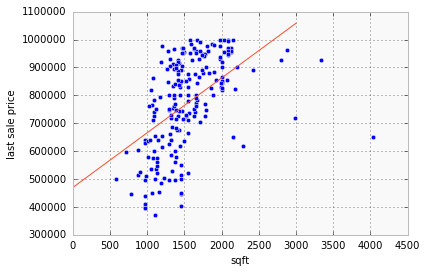

In [213]:
plt.scatter(df['SQFT'], df['LAST SALE PRICE'])
pm = 3000
plt.plot([0, pm], [f.predict([1,0])[0], f.predict([1, pm])[0]])
plt.ylabel('last sale price')
plt.xlabel('sqft')
plt.xlim(0,4500)
plt.show()

In [220]:
cols = ['intercept', 'BEDS', 'BATHS', 'SQFT']#, 'LOT SIZE', 'YEAR BUILT', 'PARKING SPOTS', 'IS SHORT SALE', 'intercept']
y = df['LAST SALE PRICE']
X = sm.add_constant(df[cols])
est = sm.OLS(y, X, missing='drop').fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LAST SALE PRICE   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     32.01
Date:                Sun, 07 Feb 2016   Prob (F-statistic):           4.72e-17
Time:                        06:00:18   Log-Likelihood:                -2809.5
No. Observations:                 212   AIC:                             5627.
Df Residuals:                     208   BIC:                             5640.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
intercept   4.731e+05   3.63e+04     13.022      0.000      4.01e+05  5.45e+05
BEDS        2.793e+04   1.81e+04      1.540      0.125     -7828.333  6.37e+04
BATHS      -6.865e+04   1.73e+04     -3.966      0.000     -1.03e+05 -3.45e+04
SQFT         233.8342     34.351      6.807      0.000       166.114   301.555
==============================================================================
Omnibus:                       13.193   Durbin-Watson:                   1.805
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.949
Skew:                          -0.564   Prob(JB):                     0.000936
Kurtosis:                       3.553   Cond. No.                     6.14e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [221]:
print est.params

intercept    473080.471119
BEDS          27930.732405
BATHS        -68652.809718
SQFT            233.834190
dtype: float64


In [30]:
df.columns

Index([u'SALE TYPE', u'HOME TYPE', u'ADDRESS', u'CITY', u'STATE', u'ZIP',
       u'LIST PRICE', u'BEDS', u'BATHS', u'LOCATION', u'SQFT', u'LOT SIZE',
       u'YEAR BUILT', u'PARKING SPOTS', u'PARKING TYPE', u'DAYS ON MARKET',
       u'STATUS', u'NEXT OPEN HOUSE DATE', u'NEXT OPEN HOUSE START TIME',
       u'NEXT OPEN HOUSE END TIME', u'RECENT REDUCTION DATE',
       u'ORIGINAL LIST PRICE', u'LAST SALE DATE', u'LAST SALE PRICE',
       u'URL (SEE http://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)',
       u'SOURCE', u'LISTING ID', u'ORIGINAL SOURCE', u'FAVORITE',
       u'INTERESTED', u'LATITUDE', u'LONGITUDE', u'IS SHORT SALE'],
      dtype='object')